In [2]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision as tv
from PIL import Image
import numpy as np
import math
from matplotlib import pyplot as plt


import utils 
import evaluate as eva

In [3]:
train_set, test_set = utils.data_load('./data')
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50000, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000, shuffle=False, num_workers=0)
train_data_interator = enumerate(train_loader)
test_data_interator = enumerate(test_loader)
train_data = next(train_data_interator)
test_data = next(test_data_interator)
train_data, train_labels, test_data, test_labels = train_data[1][0], train_data[1][1], test_data[1][0], test_data[1][1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
class KNN():
    def __init__(self):
        self.model_name = "KNN"
    def train(self, train_data, train_labels):
        self.X_train = train_data
        self.Y_train = train_labels
    def predict(self, X, k, vec=True):
        """
        功能: 预测输入图片的标签
        输入: 
            X(tensor), (M, 3*32*32): 输入的图片
            k(int), (1): 按k个邻居结点判断类别
            vec(bool), (1): 是否使用向量化距离计算方式
        输出:
            label(tensor), (M): 所有输入图片的预测类别
        """
        if vec:
            dist = self.cal_dist_with_vec(X)
        else:
            dist = self.cal_dist_with_loop(X)
            
        topk = self.Y_train[torch.argsort(dist, 1)[:,:k]]
        labels = []
        for each in topk:
            bin_count = torch.bincount(each)
            label = torch.argmax(bin_count)
            labels.append(label.item())
        return torch.LongTensor(labels)
    def cal_dist_with_vec(self, X):
        """
        功能：对于测试数据X, 计算其对于训练数据的L2距离。
        输入:
            X(tensor), (M,3*32*32): 需要预测的图片。
        输出:
            dist(tensor), (M, N): 每一行为每一个测试用例与所有训练集的L2距离。
        """
        d1 = torch.sum(torch.pow(X,2),1).unsqueeze(1)
        d2 = X.matmul(self.X_train.t())
        d3 = torch.sum(torch.pow(self.X_train, 2),1).unsqueeze(0)
        return torch.sqrt(d1 -2*d2 + d3)
    def cal_dist_with_loop(self, X):
        """
        功能：对于测试数据X, 计算其对于训练数据的L2距离。
        输入:
            X(tensor), (M,3*32*32): 需要预测的图片。
        输出:
            dist(tensor), (M, N): 每一行为每一个测试用例与所有训练集的L2距离。
        """
        M, N = X.size(0), self.X_train.size(0)
        dist = torch.ones(M, N)
        for i in range(M):
            for j in range(N):
                delta_x = X[i] - self.X_train[j]
                dist[i][j] = torch.sqrt(torch.sum(pow(delta_x,2)))
        return dist

In [5]:
train_data_num = 500
test_data_num = 100
X_train = train_data[:train_data_num].view(train_data_num, -1)
Y_train = train_labels[:train_data_num]
X_test = test_data[:test_data_num].view(test_data_num,-1)
Y_test = test_labels[:test_data_num]

knner = KNN()
knner.train(X_train, Y_train)
Y_predict = knner.predict(X_test,k=5,vec=True)
print("向量化Acc:{}".format(torch.sum(Y_test == Y_predict).item() / len(Y_test)))
# Y_predict = knnEr.predict(X_test,k=10,vec=False)
# print("非向量化Acc:{}".format(torch.sum(Y_test == Y_predict).item() / len(Y_test)))

向量化Acc:0.25


In [6]:
print("向量化花费时间:{}".format(eva.cal_time(knnEr.predict,X_test,10,True)))
# print("非向量化花费时间:{}".format(eva.cal_time(knnEr.predict,X_test,10,False)))

NameError: name 'knnEr' is not defined

In [7]:
k_fold = 5 # 交叉验证份数
k_classes = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
train_data_num = 500
test_data_num = 100
fold_sample_num = int(train_data_num / k_fold)
X_train = train_data[:train_data_num].view(train_data_num, -1)
Y_train = train_labels[:train_data_num]
X_test = test_data[:test_data_num].view(test_data_num,-1)
Y_test = test_labels[:test_data_num]

In [8]:
X_train_folds = torch.split(X_train, fold_sample_num, 0)
Y_train_folds = torch.split(Y_train, fold_sample_num, 0)

In [9]:

k_acc = {} # 记录准确率
for k in k_classes:
    acc_list = []
    for i in range(0, k_fold):
        X_tr = torch.cat(X_train_folds[:i]+X_train_folds[i+1:], 0)
        Y_tr = torch.cat(Y_train_folds[:i]+Y_train_folds[i+1:], 0)
        X_cv = X_train_folds[i]
        Y_cv = Y_train_folds[i]
        knner.train(X_tr, Y_tr)
        Y_cv_predict = knner.predict(X_cv, k, True)
        acc = torch.sum(Y_cv_predict == Y_cv).item() / len(Y_cv)
        acc_list.append(acc)
    k_acc[k] = acc_list
    

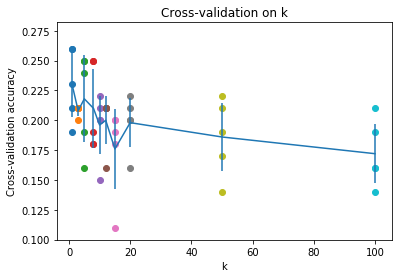

In [10]:
# Plot the cross validation
for k in k_classes:
    plt.scatter([k] * k_fold, k_acc[k])
# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = [np.mean(k_acc[k]) for k in k_acc]
accuracies_std = [np.std(k_acc[k]) for k in k_acc]
plt.errorbar(k_classes, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [317]:
knner.train(X_train, Y_train)
Y_test_predict = knner.predict(X_test,8,True)
print(torch.sum(Y_test_predict == Y_test).item() / len(Y_test))

0.24
